In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import ViTModel

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
train_dataset_path = '/content/drive/My Drive/EuroSAT_RGB/train'
test_dataset_path = '/content/drive/My Drive/EuroSAT_RGB/test'

In [43]:
# define dataset transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
class DinoV2Model(nn.Module):
    def __init__(self, num_classes=10):
        super(DinoV2Model, self).__init__()
        self.vit = ViTModel.from_pretrained('facebook/dino-vits8')
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.vit(x).last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(outputs)
        return logits

# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DinoV2Model(num_classes=10)
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DinoV2Model(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_fe

Epoch 1/10: 100%|██████████| 32/32 [00:54<00:00,  1.69s/it]


Epoch 1, Train Loss: 1.0200, Train Accuracy: 69.60%
Validation Loss: 0.4773, Validation Accuracy: 87.00%


Epoch 2/10: 100%|██████████| 32/32 [00:53<00:00,  1.66s/it]


Epoch 2, Train Loss: 0.2248, Train Accuracy: 93.10%
Validation Loss: 0.6289, Validation Accuracy: 90.00%


Epoch 3/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 3, Train Loss: 0.1765, Train Accuracy: 93.50%
Validation Loss: 0.1422, Validation Accuracy: 95.00%


Epoch 4/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 4, Train Loss: 0.0482, Train Accuracy: 98.30%
Validation Loss: 0.5003, Validation Accuracy: 93.00%


Epoch 5/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 5, Train Loss: 0.0380, Train Accuracy: 98.40%
Validation Loss: 0.2381, Validation Accuracy: 93.00%


Epoch 6/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 6, Train Loss: 0.0433, Train Accuracy: 98.80%
Validation Loss: 0.5215, Validation Accuracy: 93.00%


Epoch 7/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 7, Train Loss: 0.0327, Train Accuracy: 98.70%
Validation Loss: 0.2269, Validation Accuracy: 95.00%


Epoch 8/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 8, Train Loss: 0.0616, Train Accuracy: 98.00%
Validation Loss: 0.4801, Validation Accuracy: 92.00%


Epoch 9/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 9, Train Loss: 0.1759, Train Accuracy: 94.40%
Validation Loss: 1.3392, Validation Accuracy: 80.00%


Epoch 10/10: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Epoch 10, Train Loss: 0.2026, Train Accuracy: 94.20%
Validation Loss: 0.4135, Validation Accuracy: 93.00%


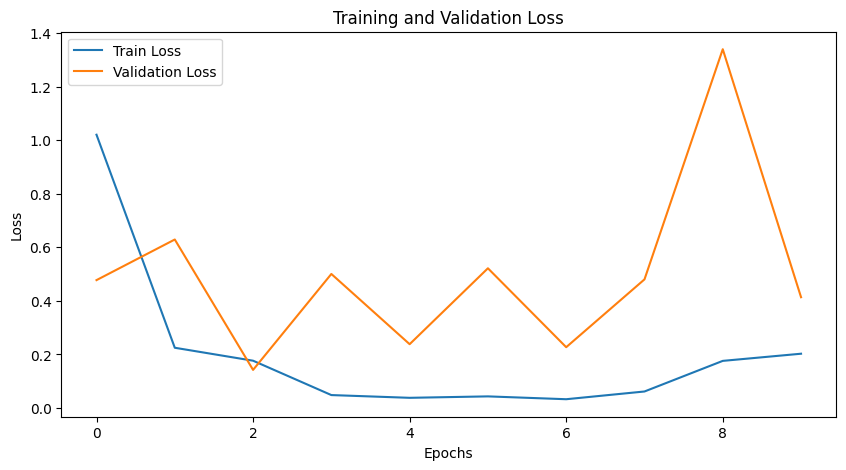

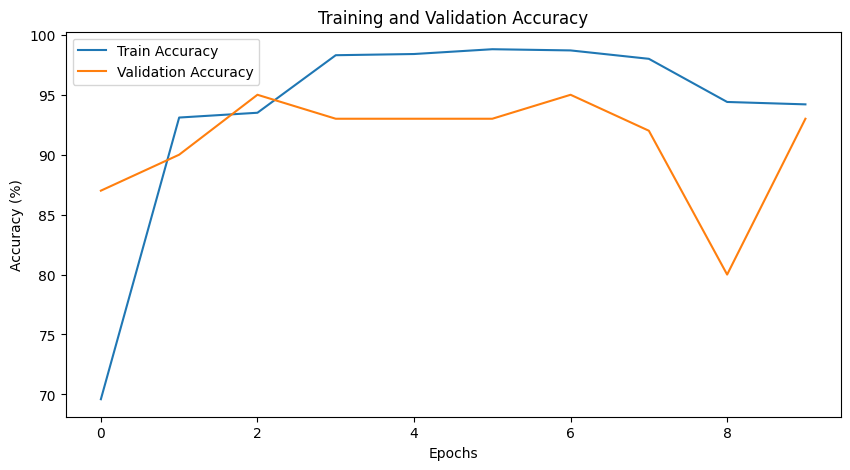

In [45]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Variables to store metrics
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Validation function
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training step
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total

    # Validation step
    val_loss, val_accuracy = validate(model, test_loader)

    # Store metrics for plotting
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Testing: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


Test Accuracy: 93.00%


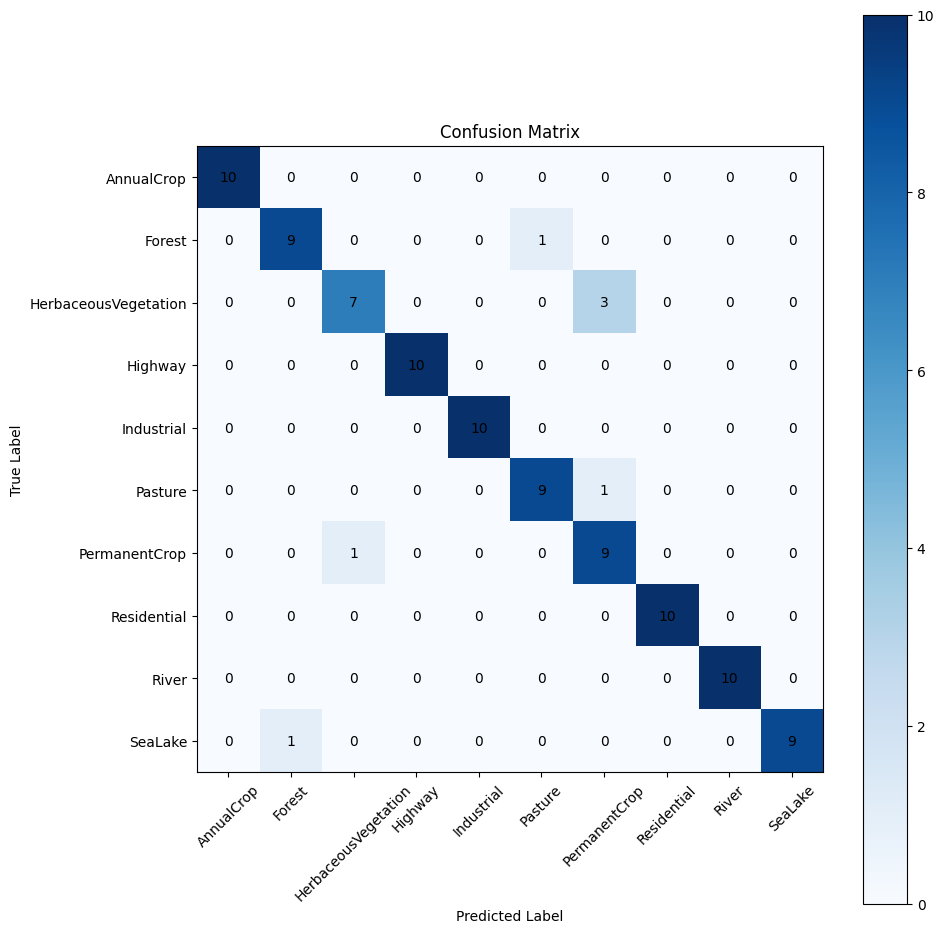

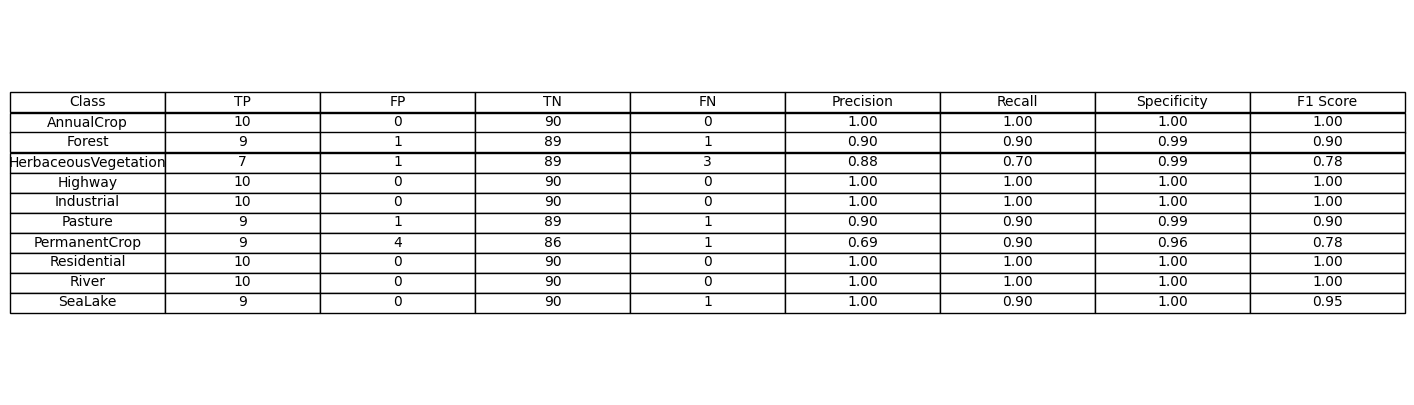

In [46]:
class_names = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

# Testing loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha='center', va='center', color='black')
plt.show()

# Function to compute metrics from the confusion matrix
def compute_metrics(conf_matrix):
    metrics = {
        'Class': [],
        'TP': [],
        'FP': [],
        'TN': [],
        'FN': [],
        'Precision': [],
        'Recall': [],
        'Specificity': [],
        'F1 Score': []
    }

    num_classes = conf_matrix.shape[0]

    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (FP + FN + TP)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics['Class'].append(class_names[i])
        metrics['TP'].append(TP)
        metrics['FP'].append(FP)
        metrics['TN'].append(TN)
        metrics['FN'].append(FN)
        metrics['Precision'].append(f"{precision:.2f}")
        metrics['Recall'].append(f"{recall:.2f}")
        metrics['Specificity'].append(f"{specificity:.2f}")
        metrics['F1 Score'].append(f"{f1_score:.2f}")

    return metrics

metrics = compute_metrics(conf_matrix)
metrics_df = pd.DataFrame(metrics)
def plot_metrics_table(metrics_df):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.show()
plot_metrics_table(metrics_df)